### Import


In [1]:
# import

import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd

from dask.distributed import Client, progress
client = Client()

import seaborn as sns, matplotlib.pyplot as plt
% matplotlib inline

import folium
from folium.plugins import HeatMap


import os
print(os.listdir("../input"))

# input file path 
data_train_file_path =   "../input/train.csv"
data_test_file_path = "../input/test.csv"

['sample_submission.csv', 'GCP-Coupons-Instructions.rtf', 'train.csv', 'test.csv']


In [2]:
client

Client Scheduler: tcp://127.0.0.1:46021 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 18.88 GB


#### Row Count

In [3]:
%%time
db_rows_count = 55423857
with open(data_train_file_path) as f:
    db_rows_count = len(f.readlines())   
print("no. of rows in the training data : {0}\n".format(db_rows_count))

no. of rows in the training data : 55423857

CPU times: user 26.4 s, sys: 18.8 s, total: 45.2 s
Wall time: 1min 29s


### Data Analysis

In [4]:
# Setting columns to most suitable type for optimisation

# training data
train_types = {'fare_amount'      : 'float32',
               'pickup_datetime'  : 'str', 
               'pickup_longitude' : 'float32',
               'pickup_latitude'  : 'float32',
               'dropoff_longitude': 'float32',
               'dropoff_latitude' : 'float32'}

# test data
test_types = { 'pickup_datetime'  : 'str',
                'key'             : 'str',
               'pickup_longitude' : 'float32',
               'pickup_latitude'  : 'float32',
               'dropoff_longitude': 'float32',
               'dropoff_latitude' : 'float32'}


# setting columns truly needed for analysis
train_cols = list(train_types.keys())    
test_cols = list(test_types.keys())  

# NY city - defining the bounding box
BB = (-74.5, -72.8, 40.5, 41.8)        

# amount of data to load from db
frac = 0.00050
    
# select within the bounding box
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])



In [5]:
def load_data(data_file_path, train_data='Y'):
    
    # training data load and filter inputs    
    if (train_data=='Y'):
        df = dd.read_csv(data_file_path,usecols=train_cols, dtype=train_types)  # data load, dask
        
        column_names = ["fare_amount",
                        "pickup_longitude",
                        "pickup_latitude", 
                        "dropoff_longitude",
                        "dropoff_latitude"]                          # selecting columns to check for empty values
        df = df.sample(frac=0.04)                                    # percentage of rows to load. (loading 2 million rows)
        df = df.dropna(how="any", subset = train_cols)               # removing rows with null values
        df = df[(df[column_names] != 0).all(axis=1)]                 # removing the latitude and longitude rows with zeros
        df = df.loc[(df.fare_amount > 0) & (df.fare_amount < 100) & 
            ~(((df.pickup_longitude - df.dropoff_longitude) == 0) & 
             ((df.pickup_latitude - df.dropoff_latitude) == 0))]     # removing the rows where fare amounts less than or greater than zero or with same coordinates
        df = df[select_within_boundingbox(df, BB)]                   #removing the coordinates not within the newyork city
    
    if (train_data == 'N'):
        df = dd.read_csv(data_file_path,usecols=test_cols, dtype=test_types)  # data load, dask
    
    df = dd.concat([
        df,dd.to_datetime(df['pickup_datetime']).apply(
        lambda x: pd.Series([x.year, x.month, x.day, x.weekday(), x.hour, x.minute],
        index=['pickup_year', 'pickup_month', 'pickup_dd' ,'pickup_weekday', 'pickup_hour', 'pickup_minute']))], axis=1)   # extract features
    df = client.persist(df) 
    return df


In [6]:
#calling the subroutine to load the data 
df = load_data(data_train_file_path, 'Y')
progress(df)

VBox()

In [7]:
# number of rows from db and after applying the filters
after = len(df)
print('# of rows in training data \n\t actual : {0}  \n\t after applying filters : {1}  \n\t dropped rows: {2} '.format(db_rows_count, after, db_rows_count-after))   # before and after filter rows count 

# of rows in training data 
	 actual : 55423857  
	 after applying filters : 2146479  
	 dropped rows: 53277378 


In [8]:
#top 10 rows
df.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_year,pickup_month,pickup_dd,pickup_weekday,pickup_hour,pickup_minute
116196,7.300000,2009-04-18 00:11:00 UTC,-73.998787,40.744759,-73.982231,40.764999,2009,4,18,5,0,11
558566,12.500000,2009-07-03 19:53:00 UTC,-73.956062,40.771847,-73.921654,40.776466,2009,7,3,4,19,53
460411,4.500000,2014-06-27 07:36:00 UTC,-73.984726,40.769108,-73.985863,40.767757,2014,6,27,4,7,36
275430,25.299999,2010-05-03 20:47:46 UTC,-73.977058,40.764229,-74.079208,40.762074,2010,5,3,0,20,47
105354,8.100000,2012-03-26 01:48:00 UTC,-73.962013,40.763798,-73.987106,40.778835,2012,3,26,0,1,48
501261,12.900000,2010-10-29 14:10:43 UTC,-73.985817,40.741287,-74.005600,40.711647,2010,10,29,4,14,10
358752,6.000000,2013-08-24 11:42:00 UTC,-73.965088,40.755878,-73.982178,40.762821,2013,8,24,5,11,42
214463,22.500000,2013-04-28 19:13:00 UTC,-73.871750,40.774040,-73.856834,40.784595,2013,4,28,6,19,13
429654,10.100000,2010-08-23 09:22:00 UTC,-73.989372,40.720886,-73.962120,40.759254,2010,8,23,0,9,22
473973,12.500000,2015-06-08 12:04:56 UTC,-73.957596,40.765980,-73.963593,40.776955,2015,6,8,0,12,4


**Row count, null check and data type:**

In [9]:
%%time
print(f'# of rows processing : {len(df)}')
print("\033[4m\nColumn Name\tisnull_counts\tdata_types\033[0m")
for columns in df.columns:
    print(f'{columns.ljust(17)}\t{(df[columns].isnull().map_partitions(sum).compute().sum()):>5}\t{(df[columns].dtype)}')
print('\t')

# of rows processing : 2146479

Column Name	isnull_counts	data_types
fare_amount      	    0	float32
pickup_datetime  	    0	object
pickup_longitude 	    0	float32
pickup_latitude  	    0	float32
dropoff_longitude	    0	float32
dropoff_latitude 	    0	float32
pickup_year      	    0	int64
pickup_month     	    0	int64
pickup_dd        	    0	int64
pickup_weekday   	    0	int64
pickup_hour      	    0	int64
pickup_minute    	    0	int64
	
CPU times: user 4.97 s, sys: 309 ms, total: 5.28 s
Wall time: 5.66 s


### Feature Engineering

In [10]:
# distance calculation in Kilometeres
from math import cos, asin, sqrt

def distance_haversine(lon1, lat1, lon2, lat2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) * 0.62137 #2*R*asin...

In [11]:
def distance_rows(p_lon, p_lat, d_lon, d_lat):
    nyc_coord = (40.7141667, -74.0063889,)      #NYC center coordinates
    jfk_coord = (40.639722, -73.778889)         #John F. Kennedy International Airport coordinates
    ewr_coord = (40.6925, -74.168611)           #Newark Liberty International Airport coordinates
    lga_coord = (40.77725, -73.872611)          #LaGuardia Airport coordinates

    distance_between_pickup_dropoff = distance_haversine(p_lon, p_lat, d_lon, d_lat)                    # distance between pickup and dropff
    distance_between_pickup_jfk     = distance_haversine(p_lon, p_lat, jfk_coord[1], jfk_coord[0])      # distance between pickup and jfk airport
    distance_between_dropoff_jfk    = distance_haversine(jfk_coord[1], jfk_coord[0], d_lon, d_lat)      # distance between dropoff and jfk airport
    distance_between_pickup_ewr     = distance_haversine(p_lon, p_lat, ewr_coord[1], ewr_coord[0])      # distance between pickup and ewr airport
    distance_between_dropoff_ewr    = distance_haversine(ewr_coord[1], ewr_coord[0], d_lon, d_lat)      # distance between dropoff and ewr airport
    distance_between_pickup_lga     = distance_haversine(p_lon, p_lat, lga_coord[1], lga_coord[0])      # distance between pickup and lga airport
    distance_between_dropoff_lga    = distance_haversine(lga_coord[1], lga_coord[0], d_lon, d_lat)      # distance between dropoff and lga airport
    distance_between_citycenter_pickup = distance_haversine(nyc_coord[0], nyc_coord[1],p_lon, p_lat)    # distance between pickup and city center
    longitude_diff                     = p_lon - d_lon
    latitude_diff                      = p_lat - d_lat
    
    return [distance_between_pickup_dropoff,
            distance_between_pickup_jfk,
            distance_between_dropoff_jfk, 
            distance_between_pickup_ewr, 
            distance_between_dropoff_ewr, 
            distance_between_pickup_lga, 
            distance_between_dropoff_lga,
            distance_between_citycenter_pickup,
            longitude_diff,
            latitude_diff]

def calculate_coordinates_distance(df, train_data='Y'):
    # distance columns to be added to the data frame
    column_names  = ['distance_between_pickup_dropoff', 
                     'distance_between_pickup_jfk', 
                     'distance_between_dropoff_jfk', 
                     'distance_between_pickup_ewr', 
                     'distance_between_dropoff_ewr', 
                     'distance_between_pickup_lga', 
                     'distance_between_dropoff_lga',
                     'distance_between_citycenter_pickup',
                     'longitude_diff',
                     'latitude_diff']

    # pandas dataframes processing - utilizing dask
    df = dd.concat([df,df[["pickup_longitude","pickup_latitude", "dropoff_longitude","dropoff_latitude"]].apply(lambda x: pd.Series(distance_rows(*x),index=column_names), axis=1)], axis=1)

    # calculate fare per mile
    if (train_data == 'Y'):
        # remove data points less than .05 miles
        df = df.loc[df.distance_between_pickup_dropoff>0.05]
        df['fare_per_mile'] = df.fare_amount/df.distance_between_pickup_dropoff 

    #reset the index
    df = df.reset_index(drop=True)  
    df = client.persist(df)
    return df


In [12]:
# calculate the distance between the coordinates
df = calculate_coordinates_distance(df, train_data='Y')
progress(df)

VBox()

In [13]:
df.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135384 entries, 0 to 446
Data columns (total 23 columns):
fare_amount                           float32
pickup_datetime                       object
pickup_longitude                      float32
pickup_latitude                       float32
dropoff_longitude                     float32
dropoff_latitude                      float32
pickup_year                           int64
pickup_month                          int64
pickup_dd                             int64
pickup_weekday                        int64
pickup_hour                           int64
pickup_minute                         int64
distance_between_pickup_dropoff       float64
distance_between_pickup_jfk           float64
distance_between_dropoff_jfk          float64
distance_between_pickup_ewr           float64
distance_between_dropoff_ewr          float64
distance_between_pickup_lga           float64
distance_between_dropoff_lga          float64
distance_between_citycenter_pi

In [14]:
@dask.delayed
def round_decimals(x, x_decimals=2):
    return x.round(x_decimals)

@dask.delayed
def math_sqrt(x):
    return math.sqrt(x)

### Fare amount mean and standard deviation

In [15]:
fare_amount_mean = df["fare_amount"].mean()
fare_amount_standard_deviation = math_sqrt(((df["fare_amount"] - fare_amount_mean) ** 2).mean())

print("average fair amount (mean) : ${0:.2f}".format(fare_amount_mean.compute()))
print("fare amount standard deviation : ${0:.2f}\n".format(fare_amount_standard_deviation.compute()))

average fair amount (mean) : $11.26
fare amount standard deviation : $9.22



### Fare Analysis

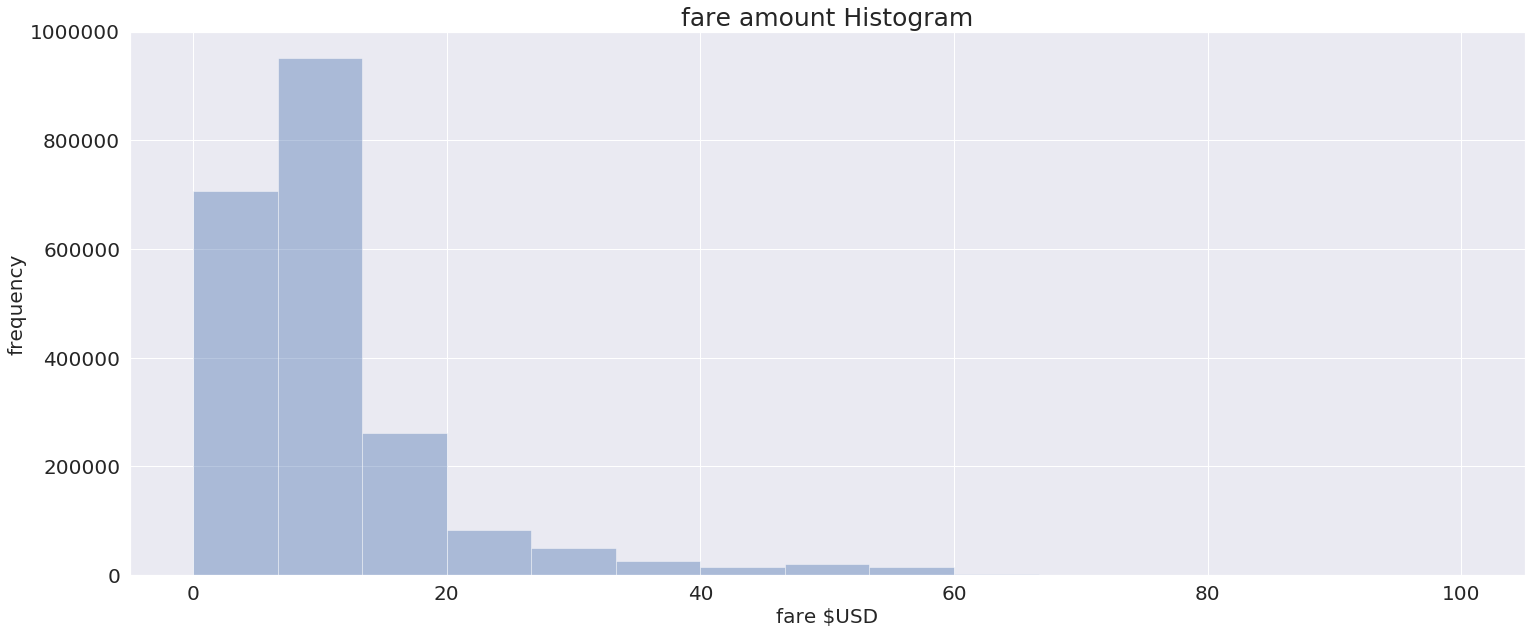

In [16]:
# plot histogram of fare
plt.figure(figsize=(25,10))
sns.set(color_codes=True)
ax = sns.distplot(df.fare_amount, bins=15, kde=False)
plt.xlabel('fare $USD', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.title('fare amount Histogram', fontsize=25)
plt.show()

### Hourly Fare Analysis

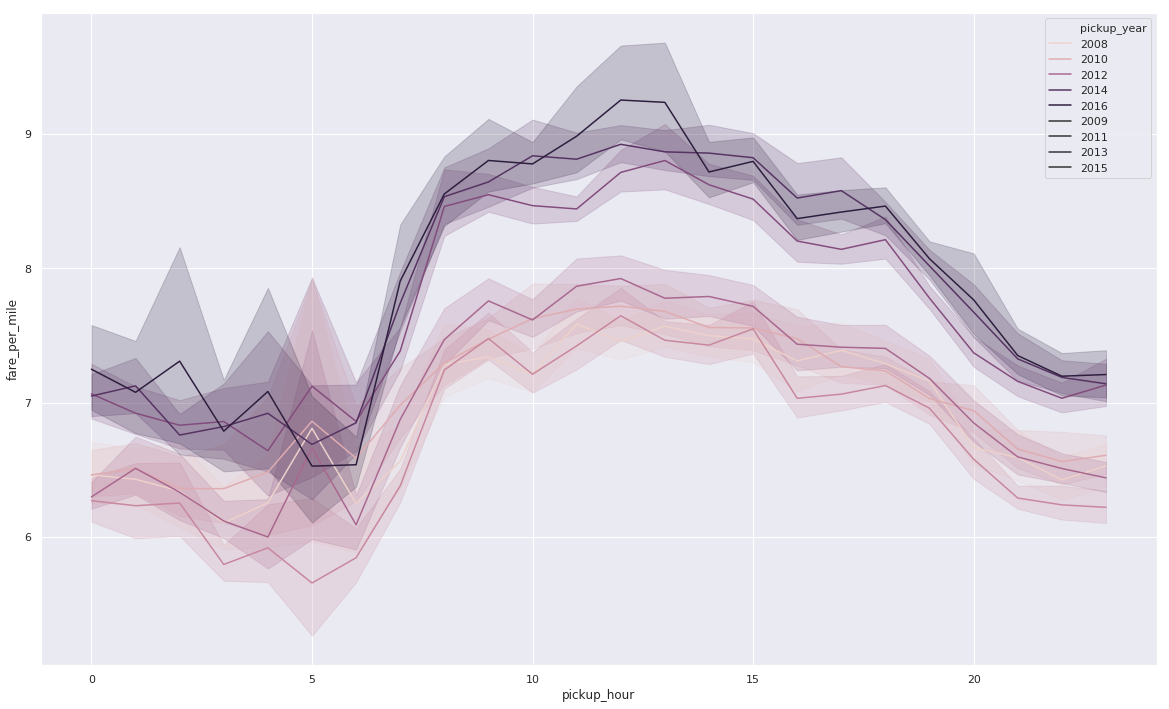

In [17]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,12))
# Plot the responses for different events and regions
sns.lineplot(x="pickup_hour", y="fare_per_mile",
            hue="pickup_year", style="pickup_year",  dashes=False, 
             data=df.compute())
plt.show()

### Fare per mile analysis on different timings 

In [18]:
df_day              = df.loc[(df.pickup_hour >=6) & (df.pickup_hour <16)]
df_peak_hours       = df.loc[((df.pickup_hour >=16) & (df.pickup_hour <20))]
df_night            = df.loc[~((df.pickup_hour >=6) & (df.pickup_hour <20))]
df_between_airports = df.loc[(((df.distance_between_pickup_jfk < 2)  | (df.distance_between_pickup_ewr < 2)  | (df.distance_between_pickup_lga < 2))  &
                              ((df.distance_between_dropoff_jfk < 2) | (df.distance_between_dropoff_lga < 2) | (df.distance_between_dropoff_ewr < 2))                      )] 
df_airport_pickup   = df.loc[((df.distance_between_pickup_jfk < 2)  | (df.distance_between_pickup_ewr < 2)  | (df.distance_between_pickup_lga < 2))]   
df_airport_dropoff  = df.loc[((df.distance_between_dropoff_jfk < 2) | (df.distance_between_dropoff_lga < 2) | (df.distance_between_dropoff_ewr < 2))] 

#remove the coordinates not within the newyork city
BB_manhattan = (-74.025, 40.7, -73.925, 40.8)
df_jfk_manhattan = df[(select_within_boundingbox(df, BB_manhattan) &
                      ((df.distance_between_pickup_jfk < 2) | (df.distance_between_dropoff_jfk < 2)))]

#reset the index
df = df.reset_index(drop=True)  

In [19]:
%%time

fare_amount_per_mile                  = df.fare_per_mile.mean().compute().round(2)

fare_amount_per_mile_day              = df_day.fare_per_mile.mean().compute().round(2)
fare_amount_per_mile_peak_hours       = df_peak_hours.fare_per_mile.mean().compute().round(2)
fare_amount_per_mile_night            = df_night.fare_per_mile.mean().compute().round(2)

fare_amount_per_mile_between_airports = df_between_airports.fare_per_mile.mean().compute().round(2)
fare_amount_per_mile_airport_pickup   = df_airport_pickup.fare_per_mile.mean().compute().round(2)
fare_amount_per_mile_airport_dropoff  = df_airport_dropoff.fare_per_mile.mean().compute().round(2)
fare_amount_per_mile_jfk_manhattan    = df_jfk_manhattan.fare_per_mile.mean().compute().round(2)

fare_amount_per_mile_weekday          = df.loc[df.pickup_weekday<=4].fare_per_mile.mean().compute().round(2)
fare_amount_per_mile_weekend          = df.loc[df.pickup_weekday>=5].fare_per_mile.mean().compute().round(2)

avg_data = pd.DataFrame({'fare':[
                    fare_amount_per_mile_between_airports,  
                    fare_amount_per_mile_jfk_manhattan,
                    fare_amount_per_mile_airport_pickup,
                    fare_amount_per_mile_airport_dropoff,
                    
                    fare_amount_per_mile_weekend,
                    fare_amount_per_mile_weekday,
                    
                    fare_amount_per_mile_peak_hours,
                    fare_amount_per_mile_night, 
                    fare_amount_per_mile_day,
                    fare_amount_per_mile
]}, index = [ 
             'between_airports', 
             'jfk_manhattan',      
             'airport_pickup', 
             'airport_dropoff', 
             'week end',  
             'week day', 
             'peak hours(4-8pm)',
             'night_ride',
             'day_ride',
             'all_day']
).dropna()

CPU times: user 10.1 s, sys: 441 ms, total: 10.5 s
Wall time: 14.9 s


### Average Fare

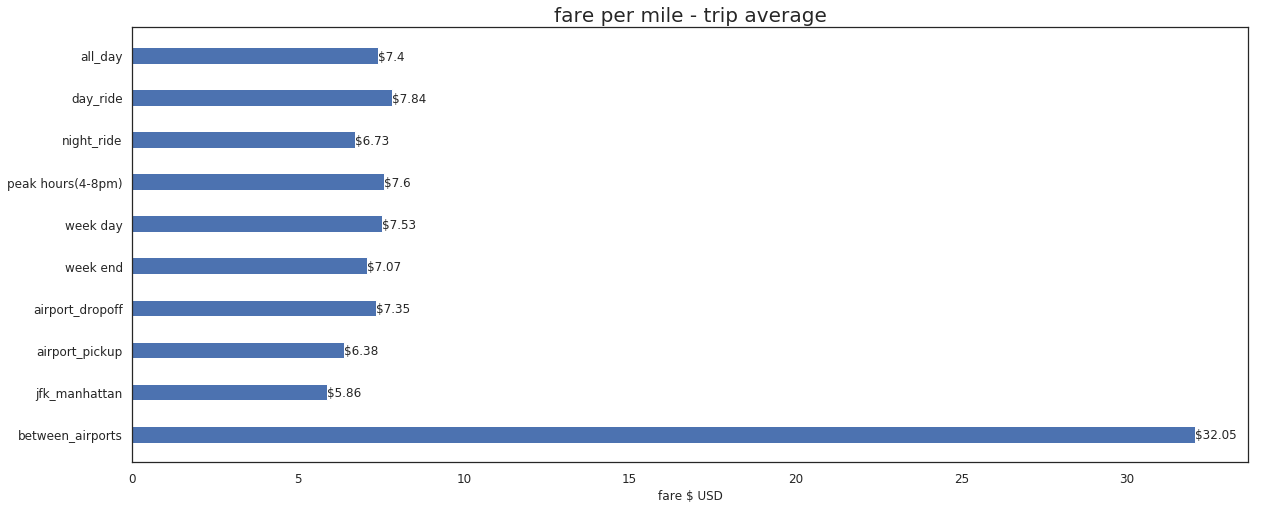

In [20]:
# average fare
sns.set_style("white")
plt.figure(figsize=(20,8))
plt.barh(avg_data.index, avg_data.fare, height = .4, align='center',  color="b")
plt.title("fare per mile - trip average", fontsize=20)
plt.xlabel('fare $ USD', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i, v in enumerate(avg_data.fare):
    plt.text(v,i-.1, '$' + str(v), fontsize=12)

Above plots shows,   
1)	Taxi charge is higher between airplane terminals voyages  
2)	Day ride charge is higher than nightly ride.  
3) Week day charge is higher than end of the week

### Fare per mile year by year analysis

In [21]:
fare_per_mile_yr                  = df.groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_day_yr              = df_day.groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_peak_hours_yr       = df_peak_hours.groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_night_yr            = df_night.groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_weekday_yr          = df.loc[df.pickup_weekday<=4].groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_weekend_yr          = df.loc[df.pickup_weekday>=5].groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_airport_pickup_yr   = df_airport_pickup.groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_airport_dropoff_yr  = df_airport_dropoff.groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_between_airports_yr = df_between_airports.groupby('pickup_year')['fare_per_mile'].mean().compute() 
fare_per_mile_jfk_manhattan_yr    = df_jfk_manhattan.groupby('pickup_year')['fare_per_mile'].mean().compute() 

fare_mile = pd.concat([
            pd.DataFrame({'year':fare_per_mile_yr.index, 'avg_fare':fare_per_mile_yr.values, 'type':'overall'}),
            pd.DataFrame({'year':fare_per_mile_day_yr.index, 'avg_fare':fare_per_mile_day_yr.values, 'type':'day_time'}),
            pd.DataFrame({'year':fare_per_mile_peak_hours_yr.index, 'avg_fare':fare_per_mile_peak_hours_yr.values, 'type':'peak_hours'}),
            pd.DataFrame({'year':fare_per_mile_night_yr.index, 'avg_fare':fare_per_mile_night_yr.values, 'type':'night_time'}),
            pd.DataFrame({'year':fare_per_mile_weekday_yr.index, 'avg_fare':fare_per_mile_weekday_yr.values, 'type':'weekend'}),
            pd.DataFrame({'year':fare_per_mile_weekend_yr.index, 'avg_fare':fare_per_mile_weekend_yr.values, 'type':'weekday'}),
            pd.DataFrame({'year':fare_per_mile_airport_pickup_yr.index, 'avg_fare':fare_per_mile_airport_pickup_yr.values, 'type':'airport_pickup'}),
            pd.DataFrame({'year':fare_per_mile_airport_dropoff_yr.index, 'avg_fare':fare_per_mile_airport_dropoff_yr.values, 'type':'airport_dropoff'}),
            pd.DataFrame({'year':fare_per_mile_jfk_manhattan_yr.index, 'avg_fare':fare_per_mile_jfk_manhattan_yr.values, 'type':'jfk_manhattan'}),
            pd.DataFrame({'year':fare_per_mile_between_airports_yr.index, 'avg_fare':fare_per_mile_between_airports_yr.values, 'type':'between_airports'}),
            ]).reset_index(drop = True)   


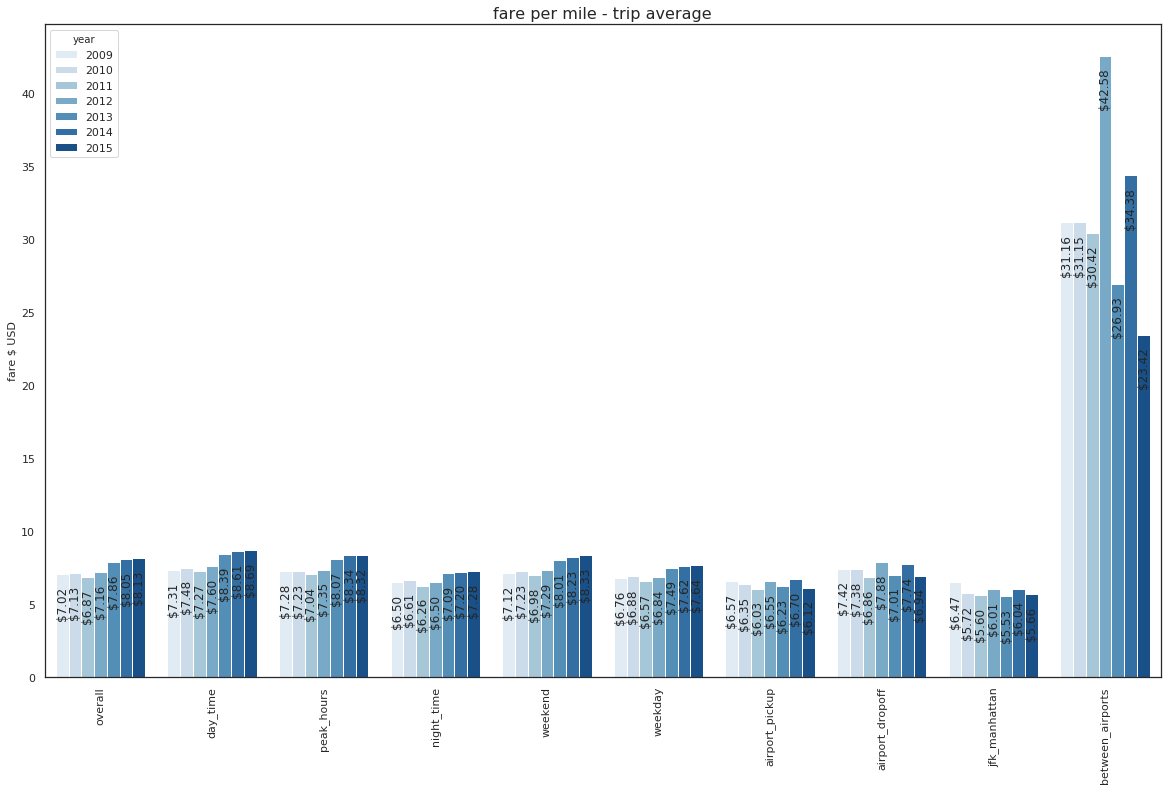

In [22]:
plt.figure(figsize=(20,12)) 
ax = sns.barplot(x="type", y="avg_fare", hue="year", data=fare_mile, palette="Blues")
plt.title("fare per mile - trip average", fontsize=16)
plt.ylabel('fare $ USD', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11, rotation =90)
plt.yticks(fontsize=11)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-1.5,
            '${:1.2f}'.format(height),
            ha="center", rotation=90) 

### Model : XGBoost

The features selected for model training.

pickup_longitude | pickup_latitude | dropoff_longitude | dropoff_latitude                       
pickup_year | pickup_month | pickup_dd | pickup_weekday | pickup_hour | pickup_minute                         

distance_between_pickup_dropoff 

distance_between_pickup_jfk | distance_between_dropoff_jfk           
distance_between_pickup_ewr | distance_between_dropoff_ewr           
distance_between_pickup_lga | distance_between_dropoff_lga       

distance_between_citycenter_pickup     

longitude_diff                         
latitude_diff                          

In [23]:
df.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135384 entries, 0 to 446
Data columns (total 23 columns):
fare_amount                           float32
pickup_datetime                       object
pickup_longitude                      float32
pickup_latitude                       float32
dropoff_longitude                     float32
dropoff_latitude                      float32
pickup_year                           int64
pickup_month                          int64
pickup_dd                             int64
pickup_weekday                        int64
pickup_hour                           int64
pickup_minute                         int64
distance_between_pickup_dropoff       float64
distance_between_pickup_jfk           float64
distance_between_dropoff_jfk          float64
distance_between_pickup_ewr           float64
distance_between_dropoff_ewr          float64
distance_between_pickup_lga           float64
distance_between_dropoff_lga          float64
distance_between_citycenter_pi

In [24]:
df.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_year,pickup_month,pickup_dd,pickup_weekday,pickup_hour,pickup_minute,distance_between_pickup_dropoff,distance_between_pickup_jfk,distance_between_dropoff_jfk,distance_between_pickup_ewr,distance_between_dropoff_ewr,distance_between_pickup_lga,distance_between_dropoff_lga,distance_between_citycenter_pickup,longitude_diff,latitude_diff,fare_per_mile
0,7.300000,2009-04-18 00:11:00 UTC,-73.998787,40.744759,-73.982231,40.764999,2009,4,18,5,0,11,1.645187,13.615404,13.724734,9.598262,10.969265,6.974456,5.798094,9370.313936,-0.016556,-0.020241,4.437185
1,12.500000,2009-07-03 19:53:00 UTC,-73.956062,40.771847,-73.921654,40.776466,2009,7,3,4,19,53,1.828453,13.017415,12.048977,12.405460,14.171328,4.382375,2.566558,9371.261114,-0.034409,-0.004620,6.836379
2,4.500000,2014-06-27 07:36:00 UTC,-73.984726,40.769108,-73.985863,40.767757,2014,6,27,4,7,36,0.110653,14.005594,13.992391,10.986859,10.889967,5.893252,5.962066,9371.621430,0.001137,0.001350,40.667665
3,25.299999,2010-05-03 20:47:46 UTC,-73.977058,40.764229,-74.079208,40.762074,2010,5,3,0,20,47,5.347809,13.481556,17.858642,11.187262,6.709774,5.538896,10.861375,9371.163022,0.102150,0.002155,4.730909
4,8.100000,2012-03-26 01:48:00 UTC,-73.962013,40.763798,-73.987106,40.778835,2012,3,26,0,1,48,1.674369,12.864752,14.536566,11.886281,11.219637,4.769540,5.991454,9370.853344,0.025093,-0.015038,4.837643
5,12.900000,2010-10-29 14:10:43 UTC,-73.985817,40.741287,-74.005600,40.711647,2010,10,29,4,14,10,2.295005,12.913878,12.877418,10.148831,8.640440,6.424625,8.307161,9369.847007,0.019783,0.029640,5.620902
6,6.000000,2013-08-24 11:42:00 UTC,-73.965088,40.755878,-73.982178,40.762821,2013,8,24,5,11,42,1.014920,12.631176,13.628269,11.521659,10.904007,5.059545,5.819307,9370.400040,0.017090,-0.006943,5.911799
7,22.500000,2013-04-28 19:13:00 UTC,-73.871750,40.774040,-73.856834,40.784595,2013,4,28,6,19,13,1.068106,10.477740,10.810168,16.531968,17.518483,0.226304,0.968953,9369.822733,-0.014915,-0.010555,21.065318
8,10.100000,2010-08-23 09:22:00 UTC,-73.989372,40.720886,-73.962120,40.759254,2010,8,23,0,9,22,3.010495,12.372642,12.662222,9.590610,11.754848,7.246964,4.846071,9368.597346,-0.027252,-0.038368,3.354930
9,12.500000,2015-06-08 12:04:56 UTC,-73.957596,40.765980,-73.963593,40.776955,2015,6,8,0,12,4,0.820647,12.795357,13.545839,12.159164,12.217258,4.514543,4.760310,9370.911350,0.005997,-0.010975,15.231875


### Train/Test Data Split

In [25]:
%%time
import xgboost as xgb
import dask_xgboost as dxgb
from sklearn.metrics import mean_squared_error

X =  df.drop(['fare_amount', 'fare_per_mile', 'pickup_datetime'], axis=1)
y =  df.fare_amount   

X_train, X_test = X.random_split([0.7, 0.3], random_state=0)
y_train, y_test = y.random_split([0.7, 0.3], random_state=0)


CPU times: user 196 ms, sys: 55 ms, total: 251 ms
Wall time: 502 ms


### Training the model

In [27]:
def dxgb_evaluate() :
    params = {'eval_metric'        : 'rmse' 
              ,'num_boost_round'   : 100
              ,'max_depth'         : 7
              ,'seed'              : 0
              ,'subsample'         : 0.8 
              ,'silent'            : True 
              ,'gamma'             : 1
              ,'colsample_bytree'  : 0.9
              ,'nfold'             : 3 
              ,'boosting_type'     : 'gbdt'
              , 'seed' : 0
         }

    bst = dxgb.train(client, params, X_train, y_train)
    del(params)
    return bst


In [28]:
# train the model
bst = dxgb_evaluate()

### Training data Prediction

In [29]:
# train split predictions
X_train_predictions = dxgb.predict(client, bst, X_train)

# train test split predictions
X_test_predictions = dxgb.predict(client, bst, X_test)

### Training data RMSE scrores

In [30]:
# Report testing and training RMSE
print("\033[1;37;40m\033[2;37:40mdata category \t\t\trmse-score\033[0m")
print('train test split \t\t\033[0;37;41m  {0:.2f}  \033[0m'.format(np.sqrt(mean_squared_error(y_test, X_test_predictions))))
print('train split \t\t\t\033[0;37;41m  {0:.2f}  \033[0m\n'.format(np.sqrt(mean_squared_error(y_train, X_train_predictions))))

[2;37:40mdata category 			rmse-score
train test split 		  3.19  
train split 			  3.14  



### Feature Importance plotting

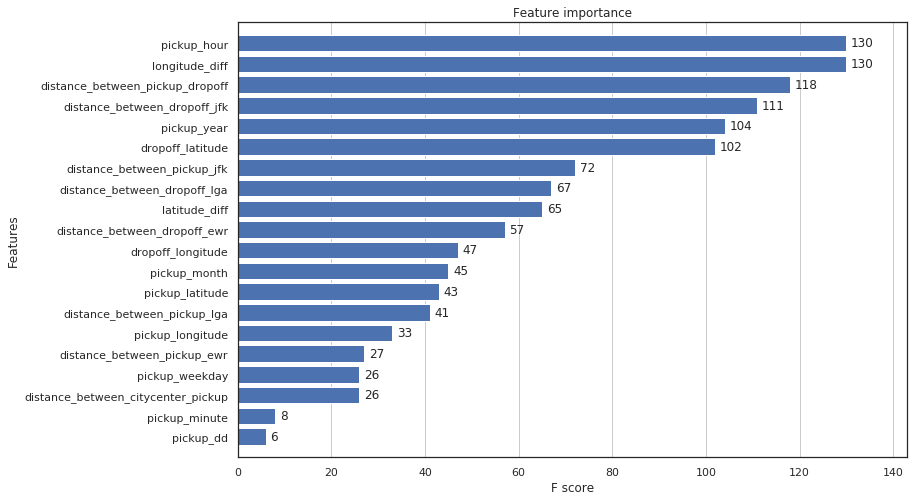

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=20, color='b')
ax.grid("off", axis="y")

In [ ]:
#for i in range(100):
#    print(s[i], y_pred[i].round(1))

### Test data predictions

In [32]:
%%time
#load the data 
df_test = load_data(data_test_file_path, train_data='N')
df_test = calculate_coordinates_distance(df_test, train_data='N')

df_test_key = df_test.key
df_test     = df_test.drop(['key', 'pickup_datetime'], axis=1)

CPU times: user 71.1 ms, sys: 4.87 ms, total: 75.9 ms
Wall time: 107 ms


In [33]:
df_test.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 20 columns):
pickup_longitude                      9914 non-null float32
pickup_latitude                       9914 non-null float32
dropoff_longitude                     9914 non-null float32
dropoff_latitude                      9914 non-null float32
pickup_year                           9914 non-null int64
pickup_month                          9914 non-null int64
pickup_dd                             9914 non-null int64
pickup_weekday                        9914 non-null int64
pickup_hour                           9914 non-null int64
pickup_minute                         9914 non-null int64
distance_between_pickup_dropoff       9914 non-null float64
distance_between_pickup_jfk           9914 non-null float64
distance_between_dropoff_jfk          9914 non-null float64
distance_between_pickup_ewr           9914 non-null float64
distance_between_dropoff_ewr          9914 non-null float64
dista

In [34]:
df_test.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_year,pickup_month,pickup_dd,pickup_weekday,pickup_hour,pickup_minute,distance_between_pickup_dropoff,distance_between_pickup_jfk,distance_between_dropoff_jfk,distance_between_pickup_ewr,distance_between_dropoff_ewr,distance_between_pickup_lga,distance_between_dropoff_lga,distance_between_citycenter_pickup,longitude_diff,latitude_diff
0,-73.973320,40.763805,-73.981430,40.743835,2015,1,27,1,13,8,1.443604,13.312535,12.819352,11.350379,10.424214,5.350990,6.145146,9371.065668,0.008110,0.019970
1,-73.986862,40.719383,-73.998886,40.739201,2015,1,27,1,13,8,1.507042,12.208493,13.419523,9.699021,9.455959,7.193762,7.112449,9368.453351,0.012024,-0.019817
2,-73.982521,40.751259,-73.979652,40.746140,2011,10,8,5,11,53,0.384263,13.159847,12.832771,10.556438,10.566417,6.025569,6.000086,9370.428602,-0.002869,0.005119
3,-73.981163,40.767807,-73.990448,40.751637,2012,12,1,5,21,12,1.218369,13.804737,13.513532,11.108395,10.184939,5.717317,6.415471,9371.470762,0.009285,0.016171
4,-73.966049,40.789776,-73.988564,40.744427,2012,12,1,5,21,12,3.347494,14.267484,13.152739,12.554612,10.088160,4.964351,6.478198,9372.604846,0.022514,0.045349


In [35]:
# train split predictions
test_predictions = dxgb.predict(client, bst, df_test)

### Submit Predictions

In [36]:
submission_predictions  = pd.DataFrame({'key': df_test_key.compute(), 'fare_amount': test_predictions.compute()})
submission_predictions.to_csv('submission.csv', index=False)

In [37]:
submission_predictions

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.232819
1,2015-01-27 13:08:24.0000003,10.456867
2,2011-10-08 11:53:44.0000002,4.697097
3,2012-12-01 21:12:12.0000002,7.643511
4,2012-12-01 21:12:12.0000003,14.821559
5,2012-12-01 21:12:12.0000005,9.973386
6,2011-10-06 12:10:20.0000001,5.298054
7,2011-10-06 12:10:20.0000003,48.095955
8,2011-10-06 12:10:20.0000002,10.743406
9,2014-02-18 15:22:20.0000002,6.259099


In [38]:
print(os.listdir('.'))

['dask-worker-space', 'submission.csv', '__notebook_source__.ipynb']
